# Weather prediction using [Ridge Regression.](https://en.wikipedia.org/wiki/Ridge_regression)

* Data source: [National Centers for Environmental Information](https://www.ncei.noaa.gov/cdo-web/search?datasetid=GHCND) (daily summaries)
* Data span: Jan 1st, 1990 untill Jan 31st, 2024
* Location: Buenos Aires (Ministro Pistarini Airport), Argentina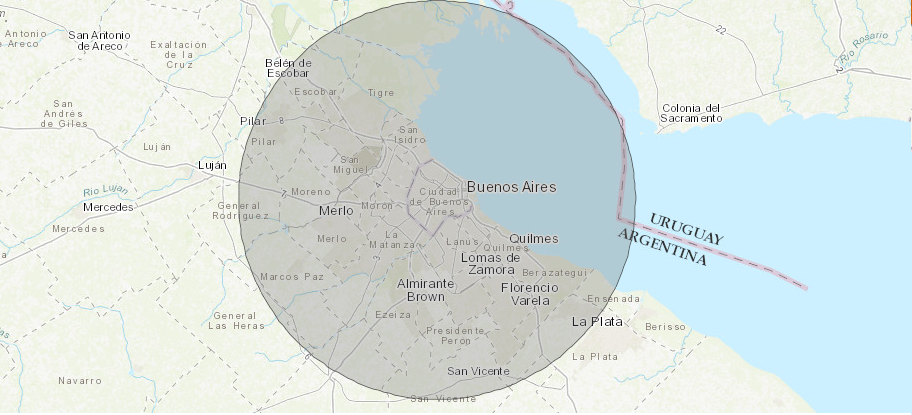


## Import libraries and data

In [5]:
import pandas as pd
import numpy as np
import io
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
from google.colab import files

### Select data file

In [6]:
data = files.upload()

Saving weather_ezeiza.csv to weather_ezeiza (9).csv


In [8]:
weather = pd.read_csv(io.BytesIO(data['weather_ezeiza.csv']),  index_col = "DATE",dtype=object)

# Handling missing data & tidying the data

Checking missing data as percentage

In [ ]:
weather.apply(pd.isnull).sum() / weather.shape[0]

Keeping core variables for weather forecast after reviewing the data documentation. For this data set, exclude snow because it doesn't snow in Buenos Aires.

Important to bear in mind:
* [Temp] = Celsius
* [Precipitation] = mm


We can state now how our linear model would look like, having in mind that the coefficients would be penalized preventing the overfitting.

Max Temp = **a** x precipitation + **b** x Max Temp + **c** x Min Temp

In [12]:
core_weather = weather[['PRCP', 'TMAX', 'TMIN']].copy()
core_weather.columns = ['precip', 'temp_max', 'temp_min']

Since we sitll have missing values, we have to deal with them, because the ML algorithm we'll apply can't handle missing values.

* For preciptiation, we could impute missing values using two strategies:

1. replace all of them with 0

2. copy the previous day values (foward fill).

  We'll try the first option for simplicity.

* For temp max and min, let's use a foward fill to impute missing data. If we inspect the df, the 1st row for temp_min is already missing. Replace it by back fill.

In [13]:
core_weather.apply(pd.isnull).sum() / core_weather.shape[0]
core_weather['precip'] = core_weather['precip'].fillna(0)
core_weather = core_weather.fillna(method='ffill')
core_weather = core_weather.fillna(method='bfill')

Check correct data types

In [14]:
core_weather.dtypes
core_weather = core_weather.astype(float)
core_weather.index = pd.to_datetime(core_weather.index)
core_weather.dtypes

precip      float64
temp_max    float64
temp_min    float64
dtype: object

# Exploratory analysis

We have to ensure the data is clean and nothing crazy is going on / nothing strange has been downloaded. If we find such a situation, we must deal with it prior to fitting any model.

## Max and min temp per year

Text(0, 0.5, 'Temperature (ºC)')

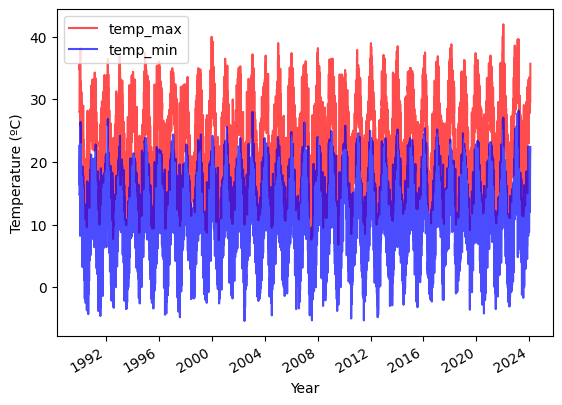

In [19]:
ax = core_weather[['temp_max', 'temp_min']].plot(alpha=0.7, color=['red', 'blue'])
ax.set_xlabel("Year")
ax.set_ylabel("Temperature (ºC)")

## Precipitation ammount per year

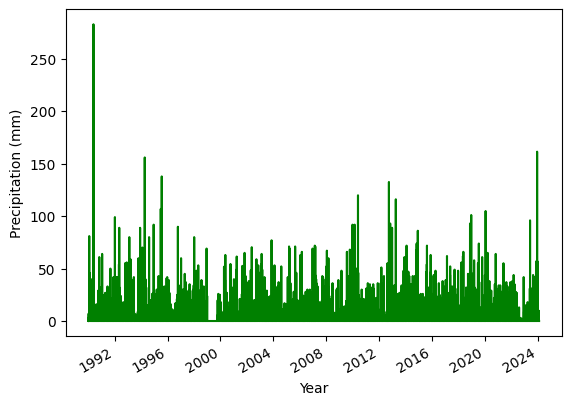

In [22]:
ax_precip = core_weather[['precip']].plot(color = 'green')
ax_precip.set_xlabel("Year")
ax_precip.set_ylabel("Precipitation (mm)")
ax_precip.get_legend().remove()



*   Our data is quite variable, as expected.
*   There is no strict consistency of precipitation registered between years
*   There is a small gap of data arround 2000s. Might be worthy to check what happened in documentation or making our own research. did somkething special happened? Did the sensors not work?



# Fitting our ML model

What do we want to predict? Tomorrow's max temp, using historical data we downloaded.


So, we should construct our **target variable** by shifting the temp max one row upwards.


In [23]:
core_weather['target'] = core_weather.shift(-1)['temp_max']
core_weather = core_weather.iloc[:-1,:].copy()#delete last row

Fitting the model and making the predictions

I can't stress this enough when working with tiem series. When splitting the data into training and testing sets, we MUST consider the cronological order.
When using time series, DO NOT RANDOMIZE the splitting procedure because we don't want to  use future data to train our model (it is logically wrong and leads to overfitting).

In [25]:
#Test/Train set
train = core_weather.loc[:'2020-12-31']
test = core_weather.loc['2021-01-01':]
#Initialize the model
reg = Ridge(alpha=0.1)
#List of predictors
predictors = ['precip', 'temp_max', 'temp_min']
#Fit model
reg.fit(train[predictors], train['target'])
#Make predictions
predictions = reg.predict(test[predictors])

Assess performance and check what we've got. First let's use our MSE metric.

In [26]:
round(mean_absolute_error(test['target'],predictions),4)

1.8006

We can say that on average we were 1.8 degrees off. Not too bad.

We can also plot observed vs. predicted values, so we can compare visually the performance of our model on the test dataset. Also we might spot any outliers or strange behaviors at this point.

Text(0, 0.5, 'Temperature (ºC)')

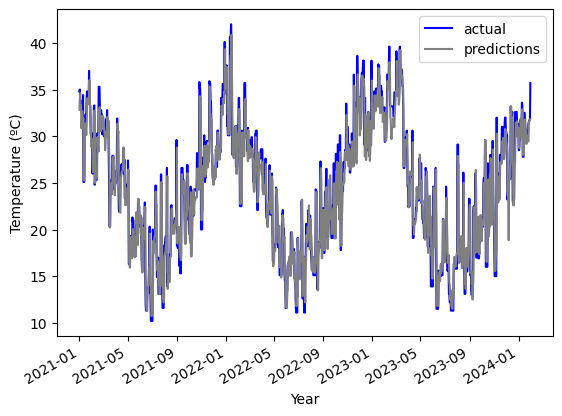

In [32]:
combined = pd.concat([test['target'], pd.Series(predictions, index=test.index)], axis=1)
combined.columns =['actual', 'predictions']
ax_comb = combined.plot(color=['blue', 'gray'])
ax_comb.set_xlabel("Year")
ax_comb.set_ylabel("Temperature (ºC)")

# Predictions

In [33]:
reg.coef_

array([-0.03682688,  0.77040515,  0.19720974])

Coefficients for model: they appear in order as they entered the model, so
we've got precip, t_max and t_min. In a way, we can interpret the coefficients as how much do they weight on predicting the next day's max tem. Thus, the present max temp seems to be the most important one (while considering core variables, next we've got an effect of the min temp and the precipitations almost have no effect.


Now, recalling our linear model, we've got:

Max Temp = -0.03 x precipitation + 0.77 x Max Temp + 0.20 x Min Temp

So replacing today's values, we can estimate tomorrows max temp, while remembering the MSE value. At the moment of writing this notebook that data were as follows

Max Temp = -0.03 x 0 + 0.77 x 34.7 + 0.20 x 25.6
Max Temp = 31.839

So we'd rather expect a very warm weather for tomorrow.
